## Yin Attack (InvertingGradients) on CIFAR-100
**Objective:** Reconstruct training data from gradients captured during federated learning simulation.


## 1. Setup and Imports


In [1]:
# Import required libraries
import time
import torch
import breaching
import torchvision
from pathlib import Path
import breaching.cases as cases
import breaching.utils as utils
import matplotlib.pyplot as plt
import breaching.attacks as attacks
import torchvision.models as models

### 2.Attack Configuration
This configuration is optimized for the highest possible fidelity, addressing the stability issues (LR), noise/blur (TV), and the architectural defense of ResNet18 (BN Stats).

| Parameter | Value | Reason |
| :--- | :--- | :--- |
| **Attack** | `invertinggradients` | The "successful" reconstruction method. |
| **Target Model** | ResNet18 | Model architecture. |
| **Dataset** | CIFAR-100 |  Target dataset. |
| **Batch Size** | 1 | Essential for perfect gradient inversion. |
| **Device** | GPU (CUDA) | Used for speed. |
| **Max Iterations** | $\mathbf{20,000}$ | Sufficient time for convergence. |
| **Learning Rate (LR)** | $\mathbf{0.001}$ | Ensures **stability** and high precision. |
| **Total Variation (TV)** | $\mathbf{1e-2}$ | Enforces **sharpness** and smoothness. |
| **Critical Fix** | $\mathbf{+reconstruct\_bn\_statistics=True}$ | **Bypasses the Batch Norm defense** for clear reconstruction. |

In [2]:
cfg = breaching.get_config(overrides=[
    "attack=invertinggradients",
    "+optim.max_iterations=20000",         
    "+optim.lr=0.001",
    "+regularization.total_variation=1e-2", 
    "+reconstruct_bn_statistics=True"
])

print(f"Attack type: {cfg.attack.type}")
if 'optim' in cfg and 'regularization' in cfg:
    print(f"Attack learning rate: {cfg.optim.lr}")
    print(f"Attack max iterations: {cfg.optim.max_iterations}")
    print(f"Total Variation Reg: {cfg.regularization.total_variation}")

Investigating use case single_imagenet with server type honest_but_curious.
Attack type: invertinggradients
Attack learning rate: 0.001
Attack max iterations: 20000
Total Variation Reg: 0.01


/users/rbhandar/.local/lib/python3.12/site-packages/breaching/__init__.py:18: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize(config_path="config"):


## 3. Load FL Gradients/ Model architecture

In [3]:
# Load saved gradients from FL simulation - CORRECT PATH
gradient_dir = Path("/scratch/project_2015432/Sec_FL_ritesh/src/attacks/fl_ritesh/reports/fedavg_baseline/round_49")
gradient_files = sorted(gradient_dir.glob("fedavg_metrics_*_tensors.pt"))
grad_file = gradient_files[0]
gradient_data = torch.load(grad_file, map_location='cpu')

model_state = gradient_data['global_model_state']
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 100)
model.load_state_dict(model_state, strict=False)
model = model.cuda()
model.eval()

loss_fn = torch.nn.CrossEntropyLoss()
setup = dict(device=torch.device('cuda'), dtype=torch.float32)
attacker = breaching.attacks.prepare_attack(model, loss_fn, cfg.attack, setup)

/users/rbhandar/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/rbhandar/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## 5. Prepare Attack Inputs: Gradients and Model State

In [4]:
# Define CIFAR-100 metadata and separate model parameters/buffers
class DataConfig:
    modality = "vision"
    size = (50_000,)
    classes = 100
    shape = (3, 32, 32)
    normalize = True
    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

data_cfg = DataConfig()

parameters = []
buffers = []
for name, tensor in gradient_data['global_model_state'].items():
    if 'running' in name or 'num_batches' in name:
        buffers.append(tensor.cuda())
    else:
        parameters.append(tensor.cuda())

server_payload = [dict(
    parameters=parameters,
    buffers=buffers,
    metadata=data_cfg
)]

print(f"Parameters: {len(parameters)}")
print(f"Buffers: {len(buffers)}")

#  get first client's gradients
client_id = list(gradient_data['raw_gradients'].keys())[0]  
client_grads = gradient_data['raw_gradients'][client_id]    

# Create gradients_ordered 
grad_dict = client_grads['grads_per_step_raw'][0]
gradients_ordered = []
for name, param in model.named_parameters():
    if name in grad_dict:
        gradients_ordered.append(grad_dict[name].cuda())
    else:
        print(f"Warning: {name} not found in gradients")

Parameters: 62
Buffers: 60


## 6. Execute Gradient Inversion Attack
**Warning:** This may take several minutes on GPU.

In [5]:
client_ids = [0, 6, 7, 12, 10]
print(f"Attacking {len(client_ids)} clients")


# The attack will perform label inference, ignoring this value.
LABEL_PLACEHOLDER = torch.tensor([0]).cuda()

for idx, cid in enumerate(client_ids):
    print(f"\n{'-'*20}")
    print(f"CLIENT {cid} ({idx+1}/5)")
    print(f"{'-'*20}")
    
    start_time = time.time()  # Track time per client
    
    client_grads = gradient_data['raw_gradients'][cid]
    grad_dict = client_grads['grads_per_step_raw'][0]
    
    gradients_ordered = []
    for name, param in model.named_parameters():
        if name in grad_dict:
            gradients_ordered.append(grad_dict[name].cuda())
    
    # Configure payload for label inference
    shared_data = [dict(
        gradients=gradients_ordered,
        buffers=None,
        metadata=dict( 
            num_data_points=1,
            labels=LABEL_PLACEHOLDER, 
            local_hyperparams=dict(
                lr=0.01, momentum=0.0, weight_decay=0.0,
                steps=1, data_per_step=1,
                labels=[LABEL_PLACEHOLDER], 
            )
        )
    )]

    
    reconstructed_user_data, stats = attacker.reconstruct(
        server_payload, shared_data, server_secrets={}, dryrun=False
    )
    
    elapsed = time.time() - start_time  # Calculate time taken
    
    # Denormalize and process image
    reconstructed_img = reconstructed_user_data['data'][0].cpu()
    img = reconstructed_img.detach().clone().permute(1, 2, 0)
    mean = torch.tensor((0.5071, 0.4867, 0.4408))
    std = torch.tensor((0.2675, 0.2565, 0.2761))
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    
    # Save image
    plt.figure(figsize=(6, 6))
    plt.imshow(img.numpy())
    plt.title(f"Client {cid} - Reconstructed (20k iter)", fontsize=14)
    plt.axis('off')
    plt.savefig(f'reconstructed_client_{cid}_20k.png', dpi=150, bbox_inches='tight')
    plt.close() 
    
    print(f"✓ Done in {elapsed/60:.1f} minutes!")  # Show actual time
    print(f"  Saved: reconstructed_client_{cid}_20k.png")
    print(f"  Mean pixel value: {reconstructed_img.mean():.3f}")
    
    torch.cuda.empty_cache()

print("\n" + "-"*20)
print("ALL 5 CLIENTS COMPLETED!")
print("-"*20)

Attacking 5 clients

--------------------
CLIENT 0 (1/5)
--------------------
✓ Done in 18.2 minutes!
  Saved: reconstructed_client_0_20k.png
  Mean pixel value: 0.442

--------------------
CLIENT 6 (2/5)
--------------------
✓ Done in 17.9 minutes!
  Saved: reconstructed_client_6_20k.png
  Mean pixel value: 0.029

--------------------
CLIENT 7 (3/5)
--------------------
✓ Done in 17.9 minutes!
  Saved: reconstructed_client_7_20k.png
  Mean pixel value: -0.385

--------------------
CLIENT 12 (4/5)
--------------------
✓ Done in 18.1 minutes!
  Saved: reconstructed_client_12_20k.png
  Mean pixel value: -0.174

--------------------
CLIENT 10 (5/5)
--------------------
✓ Done in 17.8 minutes!
  Saved: reconstructed_client_10_20k.png
  Mean pixel value: -0.274

--------------------
ALL 5 CLIENTS COMPLETED!
--------------------


## 8. Analyze Results

FileNotFoundError: [Errno 2] No such file or directory: 'reconstructed_client_0.png'

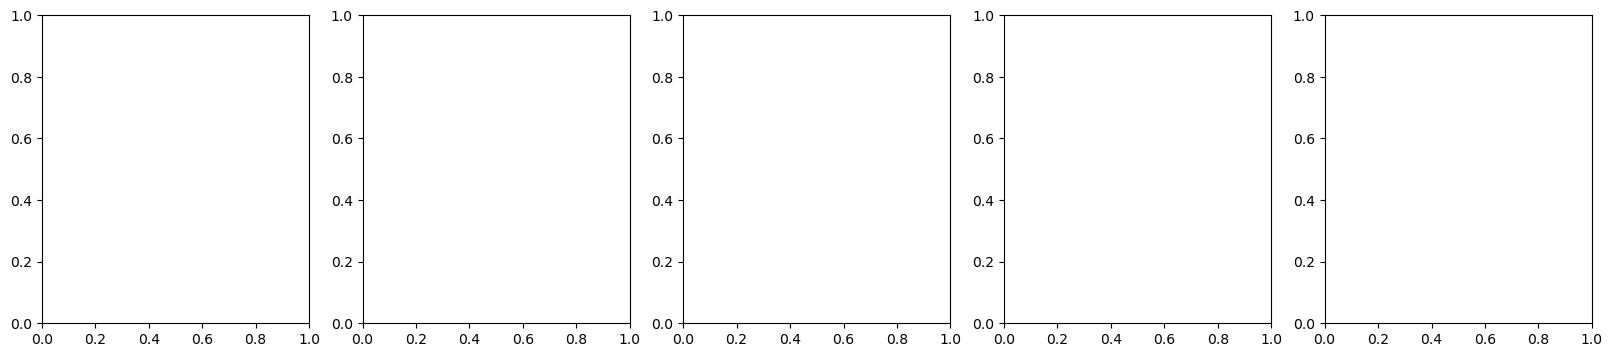

In [6]:
from PIL import Image

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, cid in enumerate([0, 6, 7, 12, 10]):
    img = Image.open(f'reconstructed_client_{cid}.png')
    axes[idx].imshow(img)
    axes[idx].set_title(f'Client {cid}', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('all_clients_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: all_clients_comparison.png")